#### cell 0：NASA C-MAPSS Data Loading + Feature Extraction Pipeline

In [1]:
import os
import requests
import pandas as pd
from pathlib import Path
from io import StringIO

#Kaggle fallback downloader (if GitHub goes down)
try:
    import kagglehub
    KAGGLE_PATH = kagglehub.dataset_download("behrad3d/nasa-cmaps")
except ImportError:
    print("Kagglehub is not installed, please manually pip install kagglehub")

# Data root directory structure
RAW_DIR = Path("raw_data_nasa")
FEAT_DIR = Path("features_nasa")
RAW_DIR.mkdir(exist_ok=True)
FEAT_DIR.mkdir(exist_ok=True)

# Common column name definitions
column_names = ['unit', 'cycle'] + [f'op_set{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]

def read_nasa_file(filename):
    """
    Try reading NASA data files from GitHub, Kaggle, and locally in sequence and caching them as .txt files.
    """
    url_github = f"https://raw.githubusercontent.com/LahiruJayasinghe/RUL-Net/master/CMAPSSData/{filename}"
    local_fallback = RAW_DIR / filename

    # Step 1: Try reading from GitHub
    try:
        print(f" Trying GitHub: {filename}")
        r = requests.get(url_github, timeout=10)
        r.raise_for_status()
        with open(local_fallback, "w") as f:
            f.write(r.text)
        print(f" Cached {filename} from GitHub")
        return pd.read_csv(StringIO(r.text), sep=r'\s+', header=None, names=column_names)
    except Exception as e:
        print(f" GitHub failed: {e}")

    # Step 2: Try reading from the kagglehub path
    try:
        print(f" Trying Kaggle: {filename}")
        kaggle_file = os.path.join(KAGGLE_PATH, "CMAPSSData", filename)
        with open(kaggle_file, "r") as f_in, open(local_fallback, "w") as f_out:
            content = f_in.read()
            f_out.write(content)
        print(f" Cached {filename} from Kaggle")
        return pd.read_csv(kaggle_file, sep=r'\s+', header=None, names=column_names)
    except Exception as e:
        print(f" Kaggle failed: {e}")

    # Step 3: Finally, fallback to the cached local
    if local_fallback.exists():
        print(f" Loading cached local file: {filename}")
        return pd.read_csv(local_fallback, sep=r'\s+', header=None, names=column_names)

    raise FileNotFoundError(f" Cannot load {filename} from any source")

def generate_features(set_id):
    print(f"\n Processing {set_id}")
    train = read_nasa_file(f"train_{set_id}.txt")
    test = read_nasa_file(f"test_{set_id}.txt")
    rul = read_nasa_file(f"RUL_{set_id}.txt")

    # If rul is a one-dimensional vector (not a DataFrame), force it to be a column
    if isinstance(rul, pd.DataFrame):
        test_y = rul
    else:
        test_y = pd.DataFrame(rul)

    # Extract X/y features
    train_X = train.drop(['unit', 'cycle'], axis=1)
    train_y = train['cycle']
    test_X = test.drop(['unit', 'cycle'], axis=1)

    #save as csv
    train_X.to_csv(FEAT_DIR / f"X_train_{set_id}.csv", index=False)
    train_y.to_csv(FEAT_DIR / f"y_train_{set_id}.csv", index=False)
    test_X.to_csv(FEAT_DIR / f"X_test_{set_id}.csv", index=False)
    test_y.to_csv(FEAT_DIR / f"y_test_{set_id}.csv", index=False)

    print(f" Features saved for {set_id} to {FEAT_DIR}/")


# Main process: Process FD001 ~ FD004
for fd in ['FD001', 'FD002', 'FD003', 'FD004']:
    try:
        generate_features(fd)
    except Exception as e:
        print(f"× Error for {fd}: {e}")


100%|██████████| 12.3M/12.3M [00:00<00:00, 193MB/s]

Extracting files...



🚀 Processing FD001
📥 Trying GitHub: train_FD001.txt
✅ Cached train_FD001.txt from GitHub
📥 Trying GitHub: test_FD001.txt
✅ Cached test_FD001.txt from GitHub
📥 Trying GitHub: RUL_FD001.txt
✅ Cached RUL_FD001.txt from GitHub
✅ Features saved for FD001 to features_nasa/

🚀 Processing FD002
📥 Trying GitHub: train_FD002.txt
✅ Cached train_FD002.txt from GitHub
📥 Trying GitHub: test_FD002.txt
✅ Cached test_FD002.txt from GitHub
📥 Trying GitHub: RUL_FD002.txt
✅ Cached RUL_FD002.txt from GitHub
✅ Features saved for FD002 to features_nasa/

🚀 Processing FD003
📥 Trying GitHub: train_FD003.txt
✅ Cached train_FD003.txt from GitHub
📥 Trying GitHub: test_FD003.txt
✅ Cached test_FD003.txt from GitHub
📥 Trying GitHub: RUL_FD003.txt
✅ Cached RUL_FD003.txt from GitHub
✅ Features saved for FD003 to features_nasa/

🚀 Processing FD004
📥 Trying GitHub: train_FD004.txt
✅ Cached train_FD004.txt from GitHub
📥 Trying GitHub: test_FD004.txt
✅ Cached test_FD004.txt from GitHub
📥 Trying GitHub: RUL_FD004.txt
✅ Ca

####Cell 1: Load the processed feature files CSVs

In [4]:
import os
import pandas as pd

#Data Path
FEATURES_DIR = "features_nasa"

# All subsets
fds = ["FD001", "FD002", "FD003", "FD004"]

# Unified management with dictionary
data = {}

for fd in fds:
    data[fd] = {
        "X_train": pd.read_csv(os.path.join(FEATURES_DIR, f"X_train_{fd}.csv")),
        "y_train": pd.read_csv(os.path.join(FEATURES_DIR, f"y_train_{fd}.csv")),
        "X_test": pd.read_csv(os.path.join(FEATURES_DIR, f"X_test_{fd}.csv")),
        "y_test": pd.read_csv(os.path.join(FEATURES_DIR, f"y_test_{fd}.csv")),
    }

print(" All features loaded successfully.")

for fd in fds:
    print(fd, data[fd]["X_train"].shape, data[fd]["y_train"].shape,
          data[fd]["X_test"].shape, data[fd]["y_test"].shape)


 All features loaded successfully.
FD001 (20631, 24) (20631, 1) (13096, 24) (100, 26)
FD002 (53759, 24) (53759, 1) (33991, 24) (259, 26)
FD003 (24720, 24) (24720, 1) (16596, 24) (100, 26)
FD004 (61249, 24) (61249, 1) (41214, 24) (248, 26)


#### Cell 2: Feature/label splitting + possible preprocessing (e.g. normalization)


In [5]:
from sklearn.preprocessing import StandardScaler

scalers = {}
for fd in fds:
    X_tr = data[fd]["X_train"]
    X_te = data[fd]["X_test"]
    scaler = StandardScaler()
    scaler.fit(X_tr)
    X_tr_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)
    X_te_scaled = pd.DataFrame(scaler.transform(X_te), columns=X_te.columns)
    # alternate data
    data[fd]["X_train_scaled"] = X_tr_scaled
    data[fd]["X_test_scaled"] = X_te_scaled
    scalers[fd] = scaler

print("Features standardized (zero mean, unit var) per FD subset.")



Features standardized (zero mean, unit var) per FD subset.


####Cell 3: Split into validation set (draw a holdout from the training set or do cross-validation setup)


In [6]:
from sklearn.model_selection import train_test_split

for fd in fds:
    X = data[fd]["X_train_scaled"]
    y = data[fd]["y_train"]
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    data[fd].update({
        "X_tr": X_tr, "X_val": X_val,
        "y_tr": y_tr, "y_val": y_val
    })
    print(f"{fd} split: train {X_tr.shape}, val {X_val.shape}")


FD001 split: train (16504, 24), val (4127, 24)
FD002 split: train (43007, 24), val (10752, 24)
FD003 split: train (19776, 24), val (4944, 24)
FD004 split: train (48999, 24), val (12250, 24)


#### Cell 4: Training a model using KNN regression + hyperparameter search

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn_models = {}

for fd in fds:
    X_tr = data[fd]["X_tr"]
    y_tr = data[fd]["y_tr"]
    knn = KNeighborsRegressor()
    param_grid = {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "p": [1, 2]  # p=1 → Manhattan distance, p=2 → Euclidean distance
    }
    grid = GridSearchCV(knn, param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
    grid.fit(X_tr, y_tr)
    best = grid.best_estimator_
    knn_models[fd] = best
    print(f"KNN best for {fd}: {grid.best_params_}")

KNN best for FD001: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
KNN best for FD002: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
KNN best for FD003: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
KNN best for FD004: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


#### Cell 5: Evaluate on validation and test sets + save predictions

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os

results = []

for fd in fds:
    model = knn_models[fd]
    X_val = data[fd]["X_val"]
    y_val = data[fd]["y_val"]
    X_te = data[fd]["X_test_scaled"]
    y_te = data[fd]["y_test"]

    print(f"{fd} shapes — X_val: {X_val.shape}, y_val: {y_val.shape}, X_te: {X_te.shape}, y_te: {getattr(y_te, 'shape', None)}")

    # If y_te is a DataFrame with more than 1 column
    if isinstance(y_te, pd.DataFrame):
        if y_te.shape[1] > 1:
            print(f"  {fd} y_te has {y_te.shape[1]} columns, keeping only first column")
            y_te = y_te.iloc[:, 0]  # turn to Series
        elif y_te.shape[1] == 1:
            y_te = y_te.iloc[:, 0]
    # If it is still two-dimensional numpy
    if isinstance(y_te, np.ndarray) and y_te.ndim > 1:
        print(f"  {fd} y_te is numpy with ndim {y_te.ndim}, flattening")
        y_te = y_te.flatten()

    #Now y_te should be a 1D array / Series

    #Alignment Length
    if X_te.shape[0] != len(y_te):
        min_n = min(X_te.shape[0], len(y_te))
        print(f"  Mismatch: X_te {X_te.shape[0]} vs y_te {len(y_te)}, truncating to {min_n}")
        X_te = X_te.iloc[:min_n].reset_index(drop=True)
        if hasattr(y_te, "iloc"):
            y_te = y_te.iloc[:min_n].reset_index(drop=True)
        else:
            y_te = y_te[:min_n]

    # predict
    y_val_pred = model.predict(X_val)
    y_te_pred = model.predict(X_te)

    mae_val = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae_te = mean_absolute_error(y_te, y_te_pred)
    rmse_te = np.sqrt(mean_squared_error(y_te, y_te_pred))

    results.append({
        "FD": fd,
        "MAE_val": mae_val, "RMSE_val": rmse_val,
        "MAE_test": mae_te, "RMSE_test": rmse_te
    })

    # Save the predictions and true values, making sure they are both one-dimensional
    df_save = pd.DataFrame({
        "truth": np.array(y_te).reshape(-1),
        "pred": np.array(y_te_pred).reshape(-1)
    })
    df_save.to_csv(os.path.join(FEATURES_DIR, f"pred_{fd}.csv"), index=False)

results_df = pd.DataFrame(results)
print("=== Evaluation Summary ===")
print(results_df)


FD001 shapes — X_val: (4127, 24), y_val: (4127, 1), X_te: (13096, 24), y_te: (100, 26)
  FD001 y_te has 26 columns, keeping only first column
  Mismatch: X_te 13096 vs y_te 100, truncating to 100
FD002 shapes — X_val: (10752, 24), y_val: (10752, 1), X_te: (33991, 24), y_te: (259, 26)
  FD002 y_te has 26 columns, keeping only first column
  Mismatch: X_te 33991 vs y_te 259, truncating to 259
FD003 shapes — X_val: (4944, 24), y_val: (4944, 1), X_te: (16596, 24), y_te: (100, 26)
  FD003 y_te has 26 columns, keeping only first column
  Mismatch: X_te 16596 vs y_te 100, truncating to 100
FD004 shapes — X_val: (12250, 24), y_val: (12250, 1), X_te: (41214, 24), y_te: (248, 26)
  FD004 y_te has 26 columns, keeping only first column
  Mismatch: X_te 41214 vs y_te 248, truncating to 248
=== Evaluation Summary ===
      FD    MAE_val   RMSE_val   MAE_test  RMSE_test
0  FD001  35.907474  45.573389  41.558274  47.716760
1  FD002  35.131490  44.479242  62.409266  77.334318
2  FD003  46.043308  59.50

#### KNN result visualization

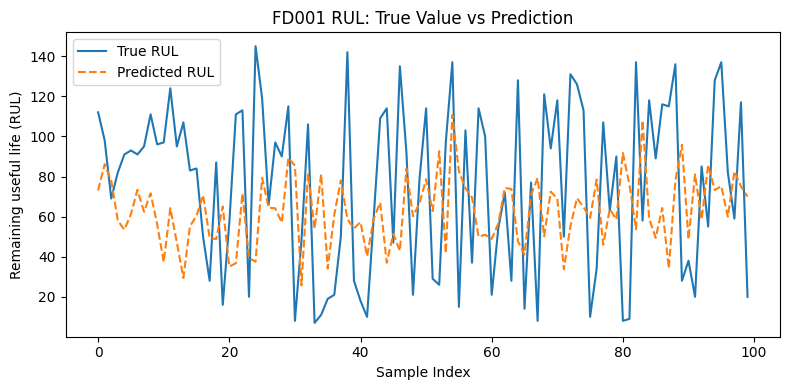

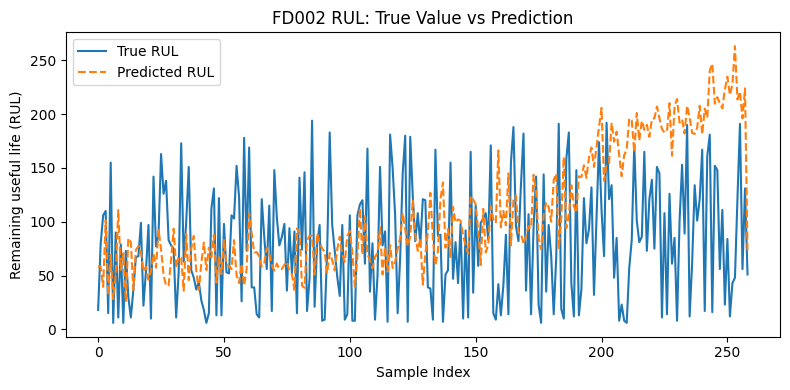

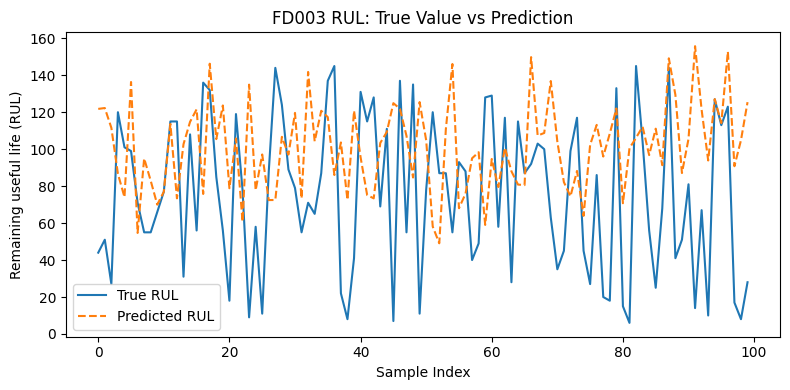

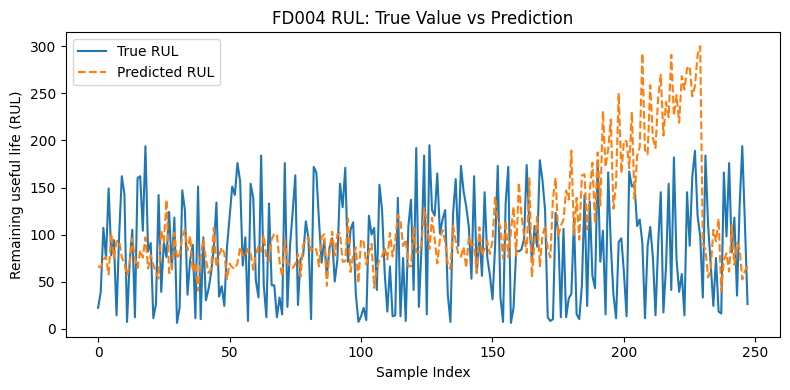

In [17]:
import matplotlib.pyplot as plt

for fd in fds:
    df_pred = pd.read_csv(os.path.join(FEATURES_DIR, f"pred_{fd}.csv"))
    plt.figure(figsize=(8,4))
    plt.plot(df_pred["truth"].values, label="True RUL")
    plt.plot(df_pred["pred"].values, label="Predicted RUL", linestyle='--')
    plt.title(f"{fd} RUL: True Value vs Prediction")
    plt.xlabel("Sample Index")
    plt.ylabel("Remaining useful life (RUL)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print()


#### Naive Bayes，GaussianNB

In [19]:
#  trained using GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

nb_models = {}

for fd in fds:
    X_tr = data[fd]["X_tr"]
    y_tr = data[fd]["y_tr"]
    # GaussianNB itself has no hyperparameters that can be tuned (except var_smoothing)
    nb = GaussianNB()
    param_grid = {
        "var_smoothing": [1e-9, 1e-8, 1e-7]
    }
    grid = GridSearchCV(nb, param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
    grid.fit(X_tr, y_tr)
    best = grid.best_estimator_
    nb_models[fd] = best
    print(f"NB best for {fd}: {grid.best_params_}")


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


NB best for FD001: {'var_smoothing': 1e-07}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


NB best for FD002: {'var_smoothing': 1e-09}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


NB best for FD003: {'var_smoothing': 1e-07}
NB best for FD004: {'var_smoothing': 1e-09}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Cell 5 (NB version): Evaluate + Save Predictions

In [20]:
#Cell 5 (NB version): Evaluate + Save Predictions
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os

results_nb = []

for fd in fds:
    model = nb_models[fd]
    X_val = data[fd]["X_val"]
    y_val = data[fd]["y_val"]
    X_te = data[fd]["X_test_scaled"]
    y_te = data[fd]["y_test"]

    # Dealing with possible multi-column y_te problems is similar to the previous section
    if isinstance(y_te, pd.DataFrame):
        if y_te.shape[1] > 1:
            y_te = y_te.iloc[:, 0]
        else:
            y_te = y_te.iloc[:, 0]

    # Alignment Lines
    if X_te.shape[0] != len(y_te):
        min_n = min(X_te.shape[0], len(y_te))
        X_te = X_te.iloc[:min_n].reset_index(drop=True)
        y_te = y_te.iloc[:min_n].reset_index(drop=True)

    y_val_pred = model.predict(X_val)
    y_te_pred = model.predict(X_te)

    mae_val = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae_te = mean_absolute_error(y_te, y_te_pred)
    rmse_te = np.sqrt(mean_squared_error(y_te, y_te_pred))

    results_nb.append({
        "FD": fd,
        "MAE_val": mae_val, "RMSE_val": rmse_val,
        "MAE_test": mae_te, "RMSE_test": rmse_te
    })

    pd.DataFrame({"truth": y_te.values, "pred": y_te_pred}).to_csv(
        os.path.join(FEAT_DIR, f"pred_nb_{fd}.csv"), index=False
    )

results_nb_df = pd.DataFrame(results_nb)
print("=== NB Evaluation Summary ===")
print(results_nb_df)


=== NB Evaluation Summary ===
      FD     MAE_val    RMSE_val    MAE_test   RMSE_test
0  FD001   50.819966   64.770662   46.600000   53.158254
1  FD002  229.427269  239.991299  256.810811  263.221151
2  FD003   74.820793  104.146914   58.500000   68.865666
3  FD004  308.365388  321.229390  342.846774  348.163674


#### Cell 6 (Visual NB version)

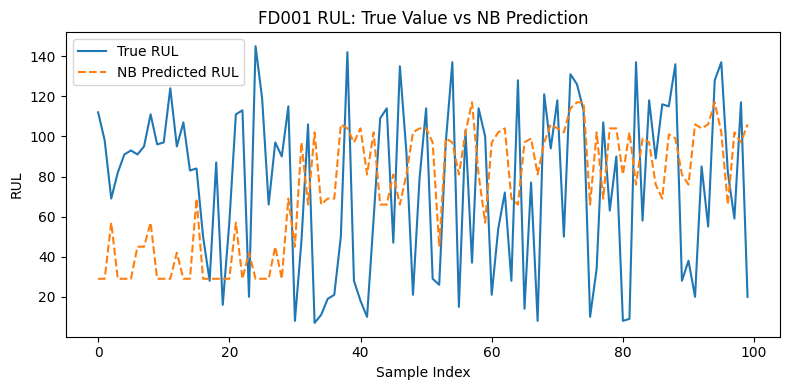

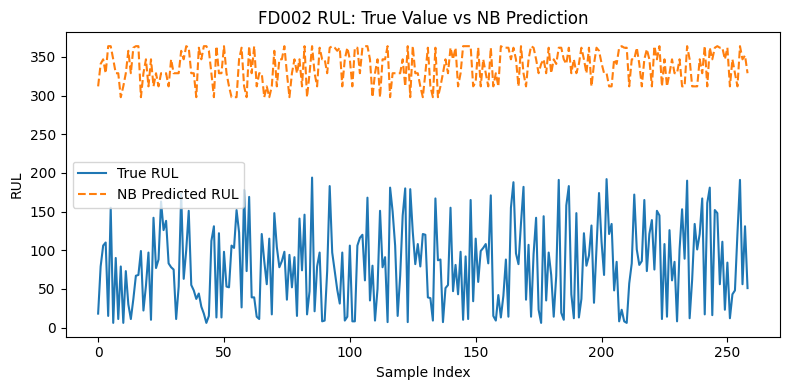

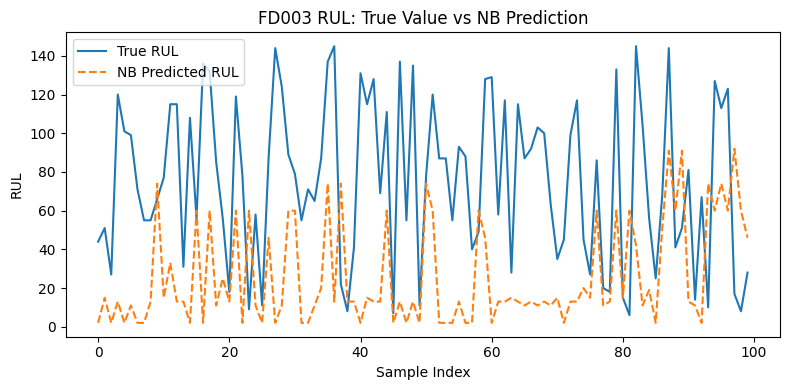

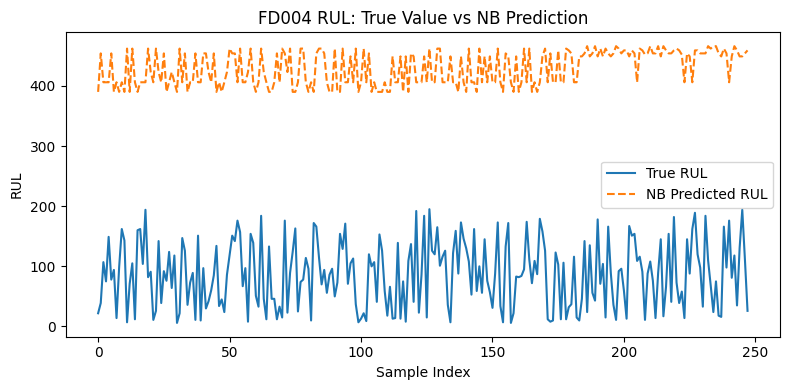

In [21]:
#Cell 6 (Visual NB version)
import matplotlib.pyplot as plt

for fd in fds:
    df_nb = pd.read_csv(os.path.join(FEAT_DIR, f"pred_nb_{fd}.csv"))
    plt.figure(figsize=(8,4))
    plt.plot(df_nb["truth"].values, label="True RUL")
    plt.plot(df_nb["pred"].values, label="NB Predicted RUL", linestyle='--')
    plt.title(f"{fd} RUL: True Value vs NB Prediction")
    plt.xlabel("Sample Index")
    plt.ylabel("RUL")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [22]:
# summary results
results_nb_df.to_csv(os.path.join(FEAT_DIR, "evaluation_summary_nb.csv"), index=False)
print("Saved NB evaluation summary to evaluation_summary_nb.csv")

Saved NB evaluation summary to evaluation_summary_nb.csv
